In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMRegressor
import lightgbm

from IPython.display import display, HTML
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES
from ficc.utils.nelson_siegel_model import yield_curve_level
from ficc.utils.diff_in_days import diff_in_days_two_dates
from ficc.utils.auxiliary_variables import NUM_OF_DAYS_IN_YEAR


INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Extension horovod.torch has not been built: /opt/conda/lib/python3.7/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-37m-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.


In [3]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="ahmad_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

Creating big query and GCP storage client

In [4]:
bq_client = bigquery.Client()
storage_client = storage.Client()

Declaring hyper-parameters

In [5]:
BATCH_SIZE = 1000
SEQUENCE_LENGTH = 5
NUM_FEATURES = 6

### Creating test set

In [6]:
import gcsfs
fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
with fs.open('ahmad_data/processed_data.pkl') as f:
    data = pd.read_pickle(f)

In [7]:
data.trade_date.min ()

Timestamp('2022-07-01 00:00:00')

Here is a list of exclusions that we will be experimenting with. The model is trained with these exclusions.
<ul>
    <li>Callable less than a year in the future </li>
    <li>Maturity less than a year in the future and more than 30 years in the future</li>
<ul>

In [8]:
data = data[(data.days_to_call == 0) | (data.days_to_call > np.log10(400))]
data = data[(data.days_to_refund == 0) | (data.days_to_refund > np.log10(400))]
data = data[(data.days_to_maturity == 0) | (data.days_to_maturity > np.log10(400))]
data = data[data.days_to_maturity < np.log10(30000)]

#### Adding features for training

In [9]:
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')

In [10]:
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')

In [11]:
auxiliary_features = ['dollar_price',
                     'calc_date', 
                     'trade_date',
                     'trade_datetime', 
                     'purpose_sub_class', 
                     'called_redemption_type', 
                     'calc_day_cat',
                     'yield',
                     'ficc_ycl',
                     'trade_history_sum',
                     'new_ficc_ycl',
                     'days_to_refund',
                     'is_called']

In [12]:
processed_data = data[IDENTIFIERS + PREDICTORS + auxiliary_features]# + ['target_attention_features','yield_spread']]

In [13]:
len(processed_data)

5883610

In [14]:
processed_data['new_ys'] = processed_data['yield'] - processed_data['new_ficc_ycl']

Isolating data to test models

In [15]:
test_dataframe = processed_data[(processed_data.trade_date >= '01-01-2023') & (processed_data.trade_date <= '01-31-2023') ]

Converting data into format suitable for the model

In [16]:
encoders = download_data(storage_client,'ahmad_data','encoders_2023-02-07-21-29.pkl')

File encoders_2023-02-07-21-29.pkl downloaded to ahmad_data.


In [17]:
def create_input(df, encoders):
    datalist = []
    datalist.append(np.stack(df['trade_history'].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

In [18]:
%%time
x_test = create_input(test_dataframe, encoders)

CPU times: user 2.62 s, sys: 90.3 ms, total: 2.71 s
Wall time: 2.71 s


### Measuring accuracy of New Yield Spread model

In [19]:
def calculate_mae(df,column_1, column_2):
    print(f"Number of samples: {len(df)}")
    return np.mean(np.abs(df[column_1] - df[column_2]))

Loading ys model

In [20]:
new_ys_model = keras.models.load_model('new_ys_model')

In [21]:
dates = []
mae = []

In [22]:
for d in [d for d in pd.date_range(start="01/01/2023",end="31/01/2023",freq='D')]:
    next_day = test_dataframe[(test_dataframe.trade_date == d)
                              & (test_dataframe.trade_type == 'D')
                             & (test_dataframe.quantity >= np.log10(500000))].copy()
    if len(next_day) == 0:
        continue
    next_day_test = create_input(next_day, encoders)  
    next_day_preds = new_ys_model.predict(next_day_test)
    error = next_day.yield_spread - next_day_preds.reshape(-1)
    MAE = np.mean(np.abs(error))
    dates.append(d.date())
    mae.append(MAE)
    print(f"Date :{d.date()} MAE:{MAE}" )

Date :2023-01-03 MAE:9.737076209585961
Date :2023-01-04 MAE:9.217086498003983
Date :2023-01-05 MAE:10.91304778657173
Date :2023-01-06 MAE:10.000391561090344
Date :2023-01-09 MAE:12.36588771503851
Date :2023-01-10 MAE:12.126327355220157
Date :2023-01-11 MAE:10.13637668739014
Date :2023-01-12 MAE:13.93240474517326
Date :2023-01-13 MAE:11.016633952333509
Date :2023-01-17 MAE:13.442061630677271
Date :2023-01-18 MAE:11.858469605900897
Date :2023-01-19 MAE:11.119176745301267
Date :2023-01-20 MAE:15.818719890088822
Date :2023-01-23 MAE:11.943689225481414
Date :2023-01-24 MAE:13.211495896741168
Date :2023-01-25 MAE:10.89516599309721
Date :2023-01-26 MAE:14.255195108517471
Date :2023-01-27 MAE:11.951551158280973
Date :2023-01-30 MAE:14.37775302733805
Date :2023-01-31 MAE:12.050009486265422


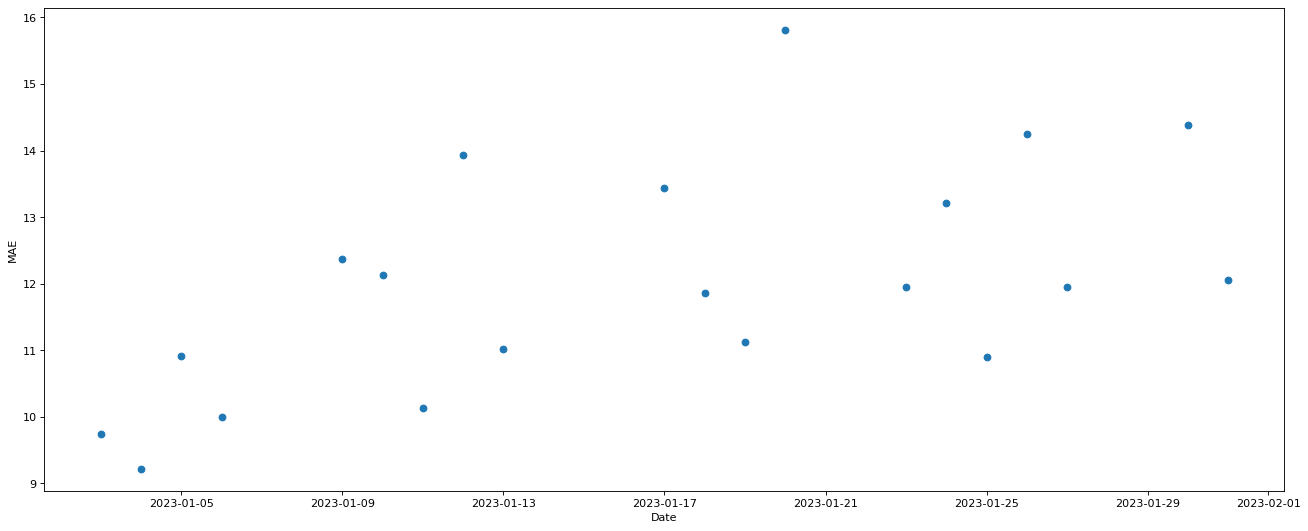

In [23]:
plt.figure(figsize=(20, 8), dpi=80)
plt.xlabel('Date')
plt.ylabel('MAE')
plt.scatter(dates, mae)

In [24]:
ys_predictions = new_ys_model.predict(x_test, batch_size=BATCH_SIZE)

In [25]:
test_dataframe['predicted_ys'] = ys_predictions

In [38]:
test_dataframe['delta'] = test_dataframe['yield_spread'] - test_dataframe['predicted_ys']

In [27]:
test_dataframe['predicted_ytw'] = test_dataframe['new_ficc_ycl'] + test_dataframe['predicted_ys']

In [28]:
test_dataframe[['new_ficc_ycl','predicted_ys','calc_date','predicted_ytw']]

,new_ficc_ycl,predicted_ys,calc_date,predicted_ytw
0,330.790860,244.287354,2039-11-15,575.078214
1,330.790860,251.496780,2039-11-15,582.287641
2,413.027871,38.862503,2052-09-01,451.890374
3,239.765872,-18.521866,2030-03-01,221.244006
4,239.765872,-12.489197,2030-03-01,227.276675
...,...,...,...,...
782301,275.616086,-19.928873,2028-10-01,255.687213
782302,275.170683,-17.135349,2028-09-01,258.035333
782303,368.882151,70.523956,2039-05-15,439.406107
782304,446.003837,-2.888664,2051-09-01,443.115173


Yiels Spread MAE

In [29]:
calculate_mae(test_dataframe,'new_ys', 'predicted_ys')

Number of samples: 674917


11.151347802868756

Yield to worst MAE

In [30]:
calculate_mae(test_dataframe,'yield','predicted_ytw')

Number of samples: 674917


11.15134780286876

Yield to worst MAE when using get_calc_date to estimate calc date

In [31]:
large_dealer_dealer_trades = test_dataframe[(test_dataframe.trade_type == 'D') & (test_dataframe.quantity >= np.log10(500000))]
calculate_mae(large_dealer_dealer_trades, 'yield_spread', 'predicted_ys')

Number of samples: 13832


11.940573749887093

In [32]:
from scipy import stats

def mkeasy(df):
    df = df[df.trade_type != "P"]
    df = df[df.quantity > np.log10(3e5 - 1)]
    df = df[df.last_size > np.log10(3e5 - 1)]
    # df = df[df.federal_tax_status != 3]
    df = df[~df.par_issue]
    df = df[df.mindays > 180]
    df = df[df.trade_datetime != pd.to_datetime("2022-11-29T16:00:14")]
    return df.copy()

def dailyskew(df, feat='coupon', val='all', metric='error', month=0):
    if month > 0: df = df[df.month == month]
    z = np.nan_to_num( stats.zscore(df[metric], nan_policy='omit'), 99)
    df = df[np.abs(z) < 9]
    other = df[df[feat] != val]
    otherdaily = other.groupby('trade_date')[metric]
    if val == 'all':
        skew = otherdaily.mean()
        delta = 2 * otherdaily.std() / np.sqrt( otherdaily.count() )
    else:
        these = df[df[feat] == val]
        thesedaily = these.groupby('trade_date')[metric]
        skew = thesedaily.mean() - otherdaily.mean()
        delta = otherdaily.std() / np.sqrt( otherdaily.count() ) + thesedaily.std() / np.sqrt( thesedaily.count() )
    avg = skew.mean()
    print( f"mean {avg:5.2f} +/- {skew.std():4.2f}  autocorr {skew.autocorr():4.2f}" )
    plt.figure(figsize=(12,4))
    plt.errorbar(x=skew.index, y=skew, yerr=delta, fmt='bo')

mean -2.86 +/- 1.40  autocorr 0.26


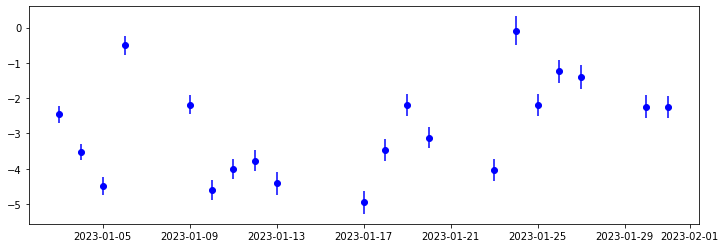

In [39]:
dailyskew(test_dataframe, metric='delta')